# Klasifikasi Citra Kanker Kulit dengan Deep Learning

Metode Sebelum data di load:
-  Dataset berasal dari dari kaggle (Skin Cancer MNIST: HAM10000).
-  Dataset dikelompokkan di folder yang berbeda sesuai kelasnya.
-  Dataset ditransformasi sehingga ukurannya 224x224.

### Data Preparation

In [ ]:
!gdown 1_1fJO5hyo50rpFyue35LSon9gyvucjhx

Downloading...
From: https://drive.google.com/uc?id=1_1fJO5hyo50rpFyue35LSon9gyvucjhx
To: /content/transformed_dataset.zip
100% 56.8M/56.8M [00:00<00:00, 155MB/s]


In [ ]:
!unzip transformed_dataset.zip

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders
input_folder = "dataset"
output = "splitted_dataset"

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.8, .2))

Copying files: 10015 files [00:01, 7956.88 files/s]


Rename foder val menjadi test.

In [ ]:
!mv splitted_dataset/val splitted_dataset/test

### Import Library

In [ ]:
import numpy as np
import os

import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage.io import imread
from skimage.transform import resize

import tensorflow as tf
from sklearn.metrics import confusion_matrix

from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from keras import regularizers
from tensorflow.keras.optimizers import Adam

### Data Understanding

Visualisasi data untuk tiap kelas.

Text(0.5, 1.0, 'vasc')

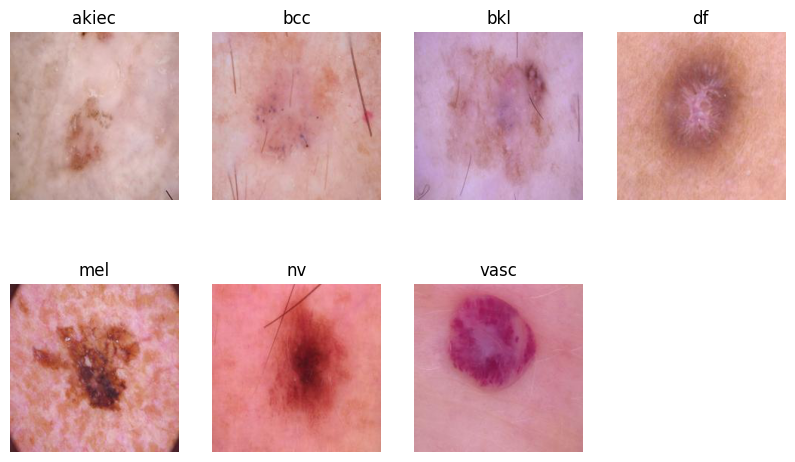

In [ ]:
fig = plt.figure(figsize=(10, 6))

# setting values to rows and column variables
rows = 2
columns = 4

# reading images
Image1 = imread('dataset/akiec/ISIC_0024329.jpg')
Image2 = imread('dataset/bcc/ISIC_0024331.jpg')
Image3 = imread('dataset/bkl/ISIC_0024312.jpg')
Image4 = imread('dataset/df/ISIC_0024318.jpg')
Image5 = imread('dataset/mel/ISIC_0024310.jpg')
Image6 = imread('dataset/nv/ISIC_0024306.jpg')
Image7 = imread('dataset/vasc/ISIC_0024370.jpg')

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("akiec")

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
# showing image
plt.imshow(Image2)
plt.axis('off')
plt.title("bcc")

# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
# showing image
plt.imshow(Image3)
plt.axis('off')
plt.title("bkl")

# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
# showing image
plt.imshow(Image4)
plt.axis('off')
plt.title("df")

# Adds a subplot at the 5th position
fig.add_subplot(rows, columns, 5)
# showing image
plt.imshow(Image5)
plt.axis('off')
plt.title("mel")

# Adds a subplot at the 6th position
fig.add_subplot(rows, columns, 6)
# showing image
plt.imshow(Image6)
plt.axis('off')
plt.title("nv")

# Adds a subplot at the 7th position
fig.add_subplot(rows, columns, 7)
# showing image
plt.imshow(Image7)
plt.axis('off')
plt.title("vasc")

### Data Preparation

In [ ]:
!rm -r splitted-dataset/test/.ipynb_checkpoints
!rm -r splitted-dataset/train/.ipynb_checkpoints

rm: cannot remove 'splitted-dataset/test/.ipynb_checkpoints': No such file or directory
rm: cannot remove 'splitted-dataset/train/.ipynb_checkpoints': No such file or directory


In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 128
base_dir = os.path.join('splitted_dataset/train')

#Train-val set
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='training')
val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation')

#Test set
X_test = []
y_test = []
labels = ['akiec','bcc','bkl','df','mel','nv','vasc']

for i,label in enumerate(labels):
    folder = os.path.join("splitted_dataset/test",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)

        image = imread(image_path)/255.
        X_test.append(image)
        category = os.path.split(folder)[-1]
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)

#Menampilkan bentuk dari masing-masing set
for image_batch, label_batch in train_generator:
  break
print("Bentuk array dari dataset train (pelatihan) adalah:", image_batch.shape,label_batch.shape)
for image_batch, label_batch in val_generator:
  break
print("Bentuk array dari dataset validation (validasi) adalah:", image_batch.shape,label_batch.shape)
print("Bentuk array dari dataset test (pengujian) adalah:", X_test.shape,y_test.shape)

Found 6411 images belonging to 7 classes.
Found 1599 images belonging to 7 classes.
Bentuk array dari dataset train (pelatihan) adalah: (128, 224, 224, 3) (128, 7)
Bentuk array dari dataset validation (validasi) adalah: (128, 224, 224, 3) (128, 7)
Bentuk array dari dataset test (pengujian) adalah: (2005, 224, 224, 3) (2005,)


Menyimpan label

In [ ]:
print (train_generator.class_indices)

labels_txt = '\n'.join(sorted(train_generator.class_indices.keys()))
with open('labels.txt', 'w') as f:
  f.write(labels_txt)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


### Modelling

Menerapkan transfer learning dengan base model MobileNet.

In [ ]:
IMG_SHAPE = (224, 224, 3)

base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')

17225924/17225924 [==============================] - 2s 0us/step


In [ ]:
base_model.trainable = False
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

Menambahkan layer kustom.

In [ ]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(7, activation='softmax')
])

model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 32)          294944    
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 32)          0         
                                                                 
 global_average_pooling2d_1   (None, 32)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 7)                 231       
                                                                 
Total params: 3,524,039
Trainable params: 295,175
Non-

Proses training untuk layer kustom.

In [ ]:
history = model.fit(train_generator,
                    epochs=60,
                    validation_data=val_generator)

Epoch 1/60
51/51 [==============================] - 34s 461ms/step - loss: 1.0756 - acc: 0.6648 - val_loss: 0.8209 - val_acc: 0.6886
Epoch 2/60
51/51 [==============================] - 21s 419ms/step - loss: 0.7670 - acc: 0.7205 - val_loss: 0.7577 - val_acc: 0.7248
Epoch 3/60
51/51 [==============================] - 23s 443ms/step - loss: 0.6999 - acc: 0.7481 - val_loss: 0.7546 - val_acc: 0.7267
Epoch 4/60
51/51 [==============================] - 20s 382ms/step - loss: 0.6566 - acc: 0.7624 - val_loss: 0.7544 - val_acc: 0.7436
Epoch 5/60
51/51 [==============================] - 21s 409ms/step - loss: 0.5983 - acc: 0.7841 - val_loss: 0.7150 - val_acc: 0.7480
Epoch 6/60
51/51 [==============================] - 22s 422ms/step - loss: 0.5621 - acc: 0.7957 - val_loss: 0.7226 - val_acc: 0.7505
Epoch 7/60
51/51 [==============================] - 22s 422ms/step - loss: 0.5291 - acc: 0.8085 - val_loss: 0.7315 - val_acc: 0.7461
Epoch 8/60
51/51 [==============================] - 21s 404ms/step - 

Visualisasi hasil training.

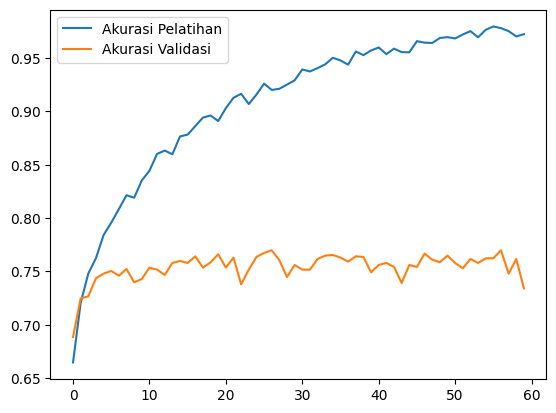

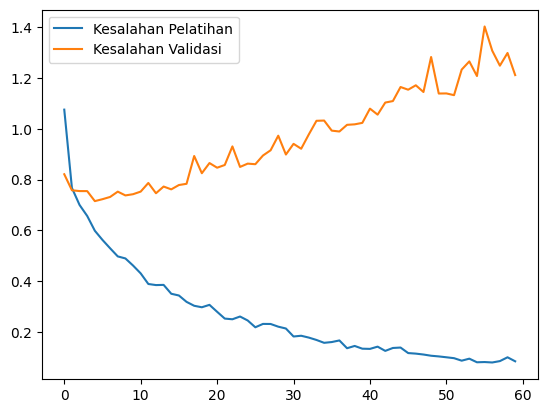

In [ ]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Akurasi Validasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kesalahan Pelatihan")
plt.plot(history.history["val_loss"],label="Kesalahan Validasi")
plt.legend()
plt.show()

Menyimpan model

In [ ]:
model.save("save_model/model.h5")

### Evaluasi

In [ ]:
from keras.utils.np_utils import to_categorical
y_test2=to_categorical(y_test)
X_test3,y_test3=(X_test,y_test2)

In [ ]:
#Memeriksa matriks model
print(model.metrics_names)
#Evaluasi data training
print(model.evaluate(train_generator))
#Evaluasi validasi data
print(model.evaluate(val_generator))
#Evaluasi data test
print(model.evaluate(x= X_test3, y = y_test3))

['loss', 'acc']
51/51 [==============================] - 17s 336ms/step - loss: 0.0693 - acc: 0.9880
[0.06931308656930923, 0.9879893660545349]
13/13 [==============================] - 4s 330ms/step - loss: 1.2117 - acc: 0.7342
[1.2116748094558716, 0.734208881855011]
63/63 [==============================] - 3s 44ms/step - loss: 1.2893 - acc: 0.7177
[1.2892986536026, 0.7177057266235352]


In [ ]:
y_true=np.argmax(y_test2,axis=1)
Y_pred=model.predict(X_test)
y_pred=np.argmax(Y_pred,axis=1)

63/63 [==============================] - 3s 42ms/step


Confusion matrix

Normalized confusion matrix
[[0.33 0.14 0.26 0.02 0.14 0.12 0.  ]
 [0.04 0.51 0.19 0.   0.13 0.12 0.01]
 [0.05 0.04 0.57 0.   0.2  0.15 0.  ]
 [0.09 0.04 0.17 0.17 0.13 0.39 0.  ]
 [0.05 0.03 0.15 0.   0.49 0.28 0.  ]
 [0.01 0.01 0.07 0.   0.08 0.83 0.  ]
 [0.   0.1  0.1  0.   0.07 0.31 0.41]]


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Label Prediksi', ylabel='Label Benar'>

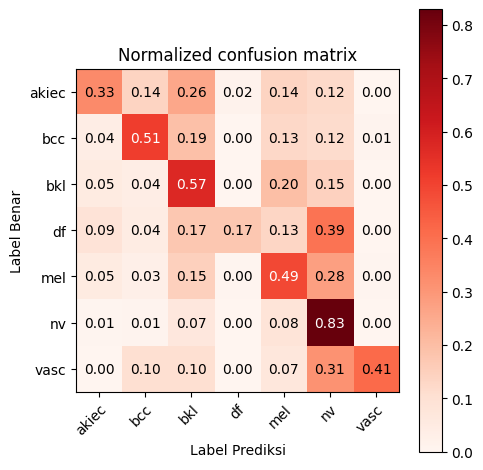

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Label Benar',
           xlabel='Label Prediksi')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

Classification report

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.38      0.33      0.35        66
           1       0.58      0.51      0.54       103
           2       0.43      0.57      0.49       220
           3       0.50      0.17      0.26        23
           4       0.37      0.49      0.42       223
           5       0.89      0.83      0.86      1341
           6       0.67      0.41      0.51        29

    accuracy                           0.72      2005
   macro avg       0.55      0.48      0.49      2005
weighted avg       0.74      0.72      0.73      2005



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

print('Accuracy: %.3f' % accuracy_score(y_true, y_pred))
print('Precision: %.3f' % precision_score(y_true, y_pred,average='weighted'))
print('Recall: %.3f' % recall_score(y_true, y_pred,average='weighted'))
print('F1 Score: %.3f' % f1_score(y_true, y_pred,average="weighted"))

Accuracy: 0.718
Precision: 0.744
Recall: 0.718
F1 Score: 0.727


### Demo Prediksi Citra

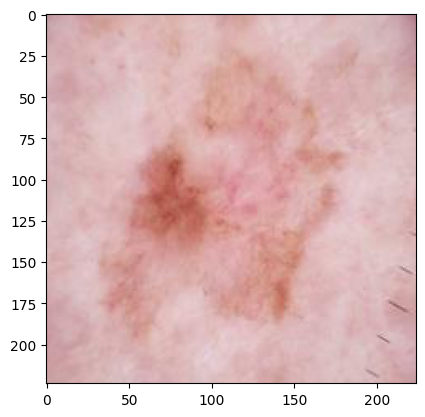

Label yang benar adalah: 0 : akiec
1/1 [==============================] - 0s 433ms/step
Nilai yang diprediksi adalah: [9.70e-01 9.29e-03 4.00e-04 2.30e-03 1.68e-03 1.60e-02 1.80e-06]
Label yang diprediksi adalah: 0 : akiec
Prediksi benar


In [ ]:
n = 2 #Jangan melampaui (nilai dari gambar test - 1)

plt.imshow(X_test[n])
plt.show()

true_label = np.argmax(y_test2,axis=1)[n]
print("Label yang benar adalah:",true_label,":",labels[true_label])
prediction = model.predict(X_test[n][np.newaxis,...])[0]
print("Nilai yang diprediksi adalah:",prediction)
predicted_label = np.argmax(prediction)
print("Label yang diprediksi adalah:",predicted_label,":",labels[predicted_label])

if true_label == predicted_label:
    print("Prediksi benar")
else:
    print("Prediksi salah")